# DBSCAN. Практическая работа

## Цель практической работы

Научиться строить модели кластеризации с помощью метода DBSCAN.

## Что входит в работу


- Загрузите данные и проведите разведочный анализ.
- Предположите оптимальное количество кластеров.
- Постройте модель кластеризации DBSCAN.
- Определите оптимальное количество и структуру кластеров.
- Интерпретируйте полученные результаты.

## Что оценивается 

1. Выполнены все задания.
2. Сделаны выводы по результатам разведочного анализа данных.
3. Объяснены выбранные гиперпараметры модели кластеризации.
4. Сделаны выводы о количестве и структуре кластеров.
5. Сделаны выводы по результатам кластеризации.

# Задача

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды. 
* AFDP — перепад давления на воздушном фильтре. 
* GTEP — давление на выходе из газовой турбины. 
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины. 
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа. 
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
import EDAFunctions
import clstr_fncts

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import pandas as pd
import hdbscan
from ydata_profiling import ProfileReport
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler, RobustScaler

warnings.filterwarnings("ignore", category=FutureWarning)

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [3]:
df = pd.read_csv('data/gt_2015.csv')
# df.rename(columns={'TEY': 'target'}, inplace=True)
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [4]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,7384.000000,7384.00000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000
mean,17.225259,1014.50911,68.647464,3.598909,26.130149,1078.974689,546.642484,133.993380,12.097025,3.129986,59.890509
std,8.095783,6.89543,13.541116,0.610226,4.473737,19.762449,5.489066,16.179208,1.136601,2.234962,11.132464
min,-6.234800,989.40000,24.085000,2.368800,17.698000,1016.000000,516.040000,100.020000,9.870800,0.212800,25.905000
25%,11.073250,1009.67500,59.447250,3.117300,23.147000,1070.500000,544.747500,126.255000,11.465750,1.808175,52.399000
50%,17.456500,1014.00000,70.952000,3.538500,25.331000,1080.300000,549.720000,131.600000,11.933000,2.533400,56.838500
75%,23.684750,1018.30000,79.653750,4.194825,30.018250,1099.900000,550.030000,147.160000,13.148000,3.702550,65.093250
max,37.103000,1036.60000,96.666000,5.239500,40.716000,1100.400000,550.590000,179.500000,15.159000,41.097000,119.680000


In [5]:
# report = ProfileReport(df)
# report.to_file("media/report.html")
# report.to_notebook_iframe()

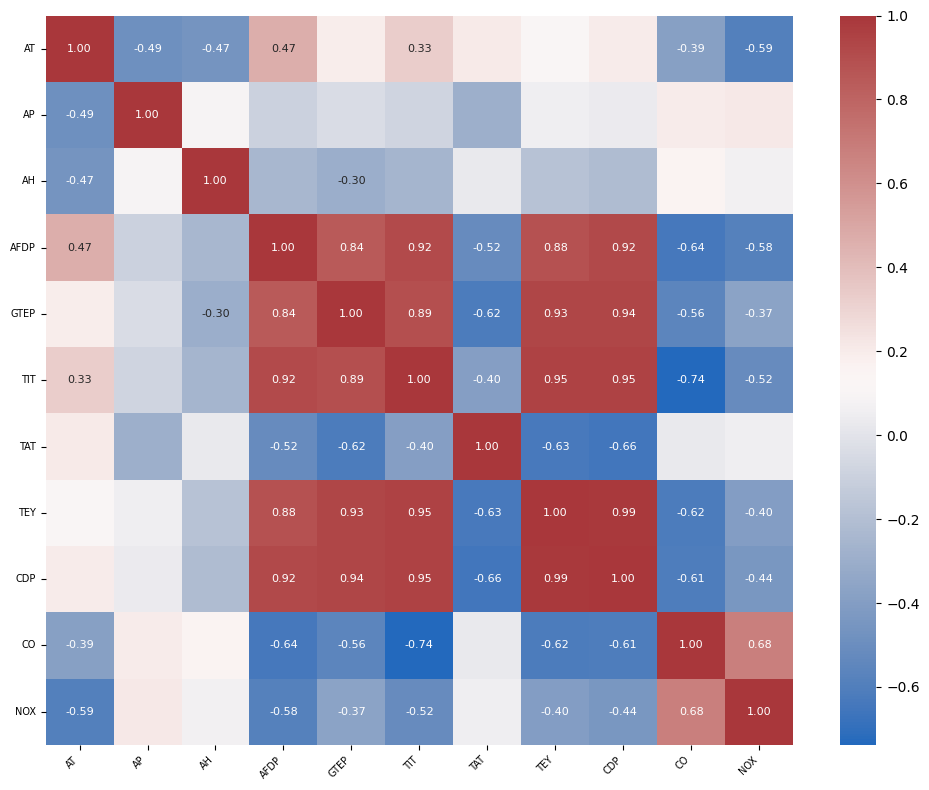

In [6]:
EDAFunctions.show_correlation_heatmap(df)

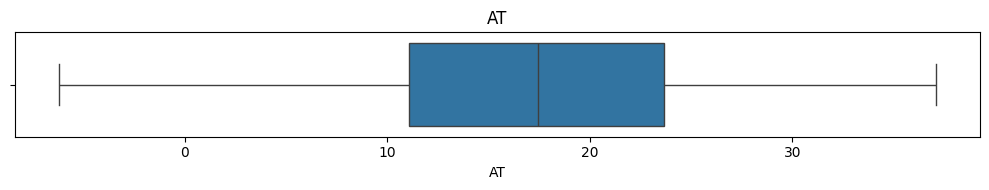

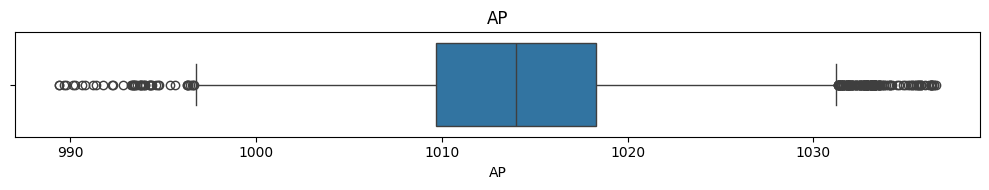

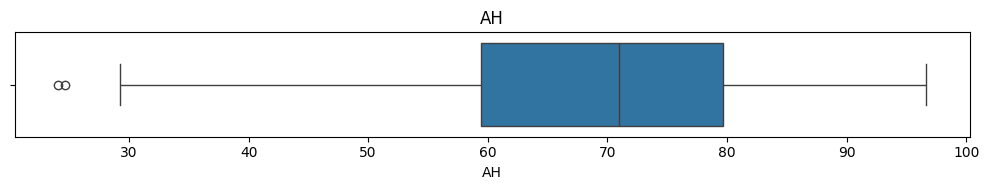

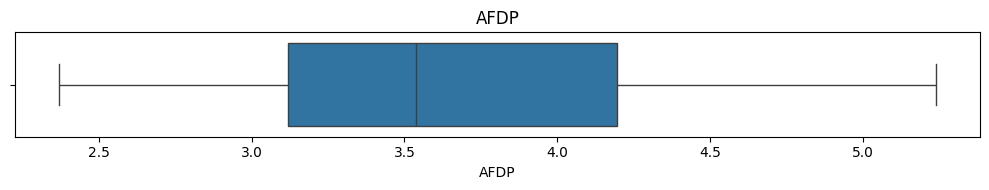

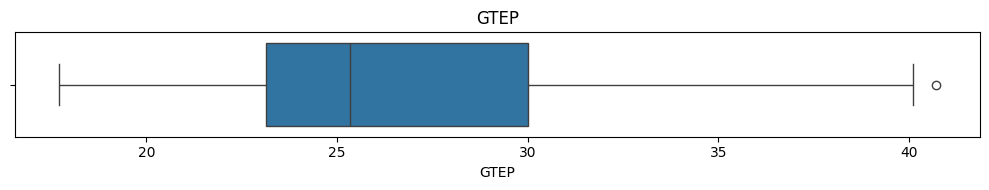

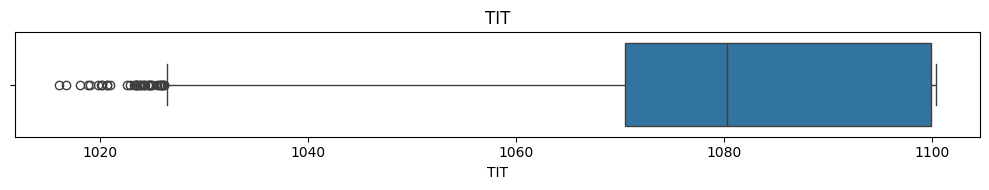

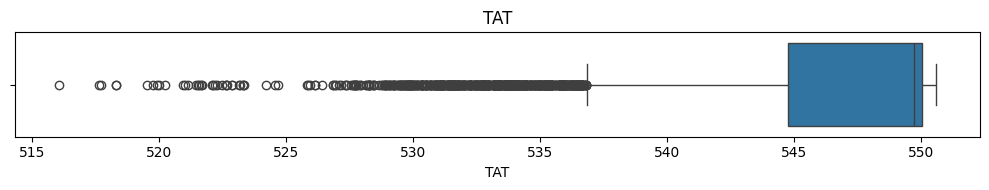

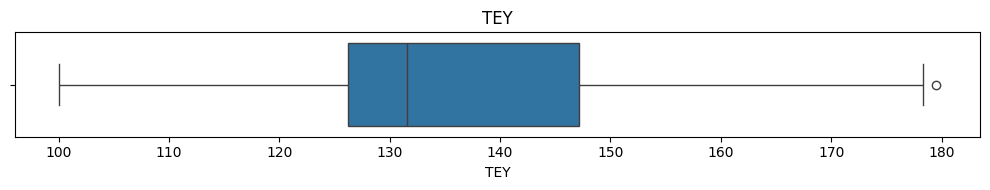

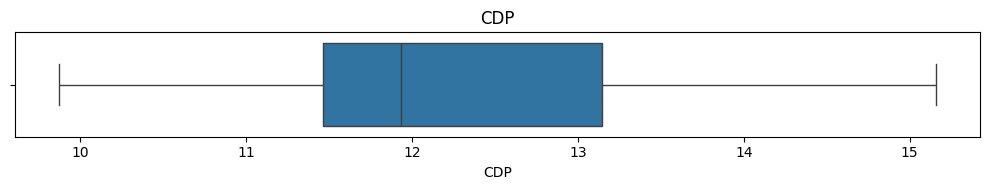

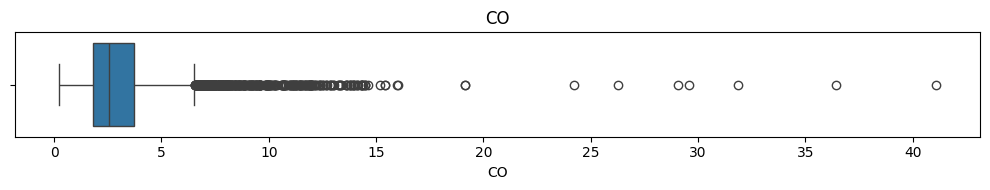

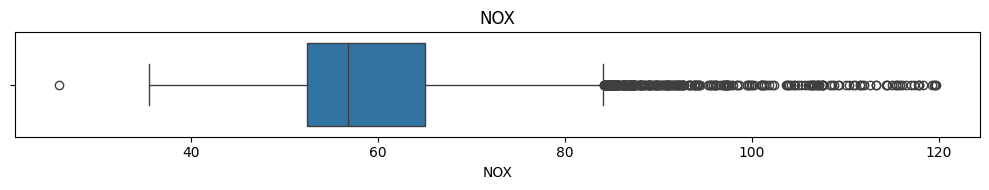

In [7]:
features = df.columns
EDAFunctions.show_box_plot(df, features)

**Судя по производительности турбин (TEY — это, видимо, таргет), у нас будет три кластера**

А поскольку я немного в этом шарю, то тут можно многое рассказать (в том числе, почему почти все показатели демонстрируют сильную корреляцию), начиная с температуры окружающего воздуха: какие-то работают в холодном климате, какие-то в умеренном, какие-то в жарком. В основном, в умеренном. По давлению: практически все находятся на уровне моря. Перепад давления на входе фильтра снова указывает на три группы турбин. Давление на выходе из турбины (оно собсна должно сильно коррелировать с предыдущим показателем) свидетельствует о том же. Ой, там ещё их много: которые делят выборку на три кластера. По выбросам: все примерно одинаковые.

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

***Три группы. Различаются по мощности. Отсюда вытекают и все остальные показатели.***

- 110 МВт - около тыщи
- 130 МВт - две тыщи
- 150 МВт - чуть меньше тыщи

Ну и промежуточных по мелочи.

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

### **3.1. В первую очередь отмасштабируем значения, чтобы не забыть.**


In [8]:
std_scaler = StandardScaler()
robust_scaler = RobustScaler()
df_std = pd.DataFrame(std_scaler.fit_transform(df), columns=df.columns)
df_robust = pd.DataFrame(robust_scaler.fit_transform(df), columns=df.columns)

### **3.2. Понизим размерность для визуализации**

In [51]:
pca = PCA(n_components=2)
pca_std = pca.fit_transform(df_std)
pca_robust = pca.fit_transform(df_robust)

tsne = TSNE(n_components=2, perplexity=100, random_state=137)
tsne_std = tsne.fit_transform(df_std)
tsne_robust = tsne.fit_transform(df_robust)

umap = UMAP(n_components=2)
umap_std = umap.fit_transform(df_std)
umap_robust = umap.fit_transform(df_robust)

### **3.3. Выполним кластеризацию**

#### **3.3.1. PCA**

In [104]:
eps_values = np.arange(.1, 10, 1)
min_sv = range(10, 100, 10)

best_params = clstr_fncts.get_best_params_DBSCAN(pca_std, eps_values, min_sv)[0]

Best params: {'eps': np.float64(4.1), 'min_samples': 50}
Best score: 0.52


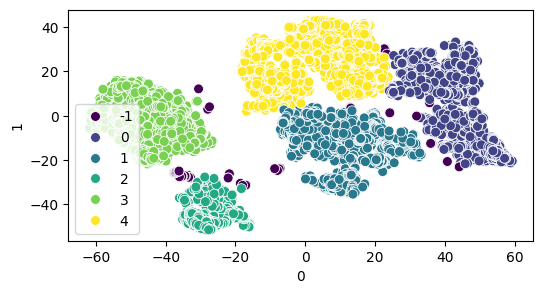

In [105]:
clstr_fncts.plot_best_params_DBSCAN(pca_std, best_params)

**Ну, интересный вариант.**

Best params: {'eps': np.float64(2.1), 'min_samples': 3}
Best score: 0.82


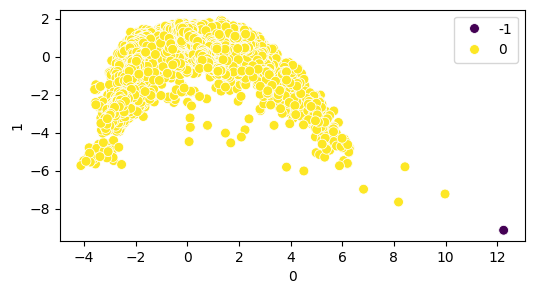

In [93]:
best_params = clstr_fncts.get_best_params_DBSCAN(pca_robust, eps_values, min_sv)[0]
clstr_fncts.plot_best_params_DBSCAN(pca_robust, best_params)

**Видно, что робастное масштабирование в этой задаче не покатит, поэтому я его использовать больше не буду.**

Best params: {'min_samples': 30}
Best score: 0.46


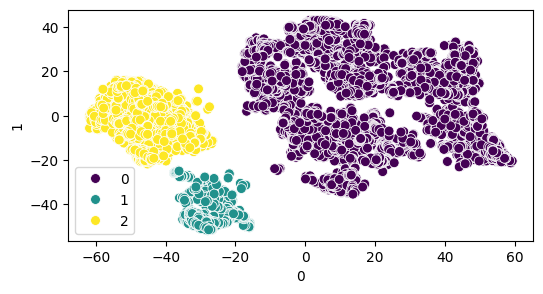

In [103]:
best_params = clstr_fncts.get_best_params_HDBSCAN(pca_std, range(10, 100, 10))[0]
clstr_fncts.plot_best_params_HDBSCAN(pca_std, best_params)

**Похоже на идеал. Ни добавить, ни отнять.**

#### **3.3.2. TSNE**

Best params: {'eps': np.float64(5.1), 'min_samples': 3}
Best score: 0.46


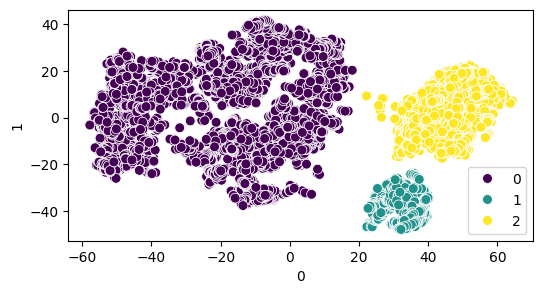

In [96]:
best_params = clstr_fncts.get_best_params_DBSCAN(tsne_std, eps_values, min_sv)[0]
clstr_fncts.plot_best_params_DBSCAN(tsne_std, best_params)

**Интересно, почему изображение повернулось относительно предыдущего? Видимо, ТСНЕ как-то в противоположную сторону понижал размерность.**

## **Глобальная структура не сохраняется в явном виде. Эта проблема решается инициализацией точек с помощью PCA (с помощью init='pca').**

Best params: {'min_samples': 20}
Best score: 0.46


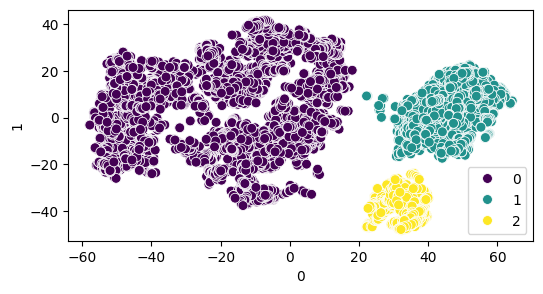

Устойчивость кластеров: [0.10622688 0.25589525 0.2067616 ]


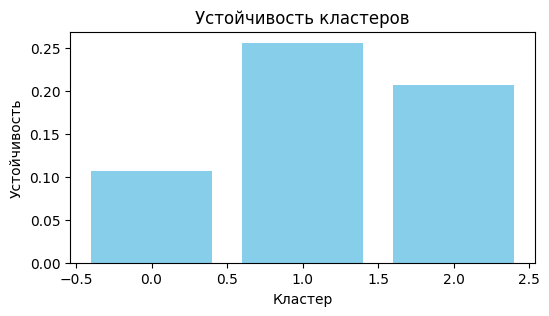

In [116]:
results = clstr_fncts.get_best_params_HDBSCAN(tsne_std, min_sv)
best_params, labels_tsne = results[0], results[2]
clstr_fncts.plot_best_params_HDBSCAN(tsne_std, best_params)

In [124]:
np.unique(labels_tsne, return_counts=True)

(array([-1,  0,  1,  2]), array([  10, 5068, 1655,  651]))

#### **3.3.3. UMAP**

Best params: {'eps': np.float64(2.1), 'min_samples': 10}
Best score: 0.54


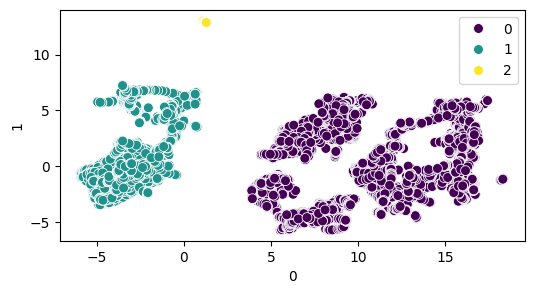

In [107]:
best_params = clstr_fncts.get_best_params_DBSCAN(umap_std, eps_values, min_sv)[0]
clstr_fncts.plot_best_params_DBSCAN(umap_std, best_params)

Best params: {'min_samples': 60}
Best score: 0.50


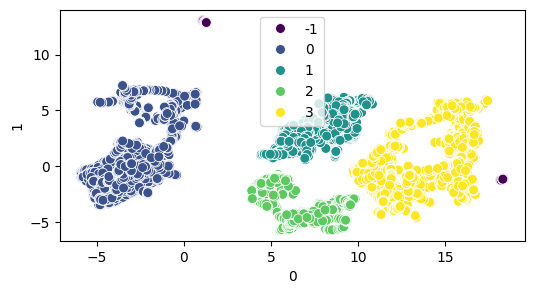

Устойчивость кластеров: [0.23888383 0.25587208 0.15785809 0.17312767]


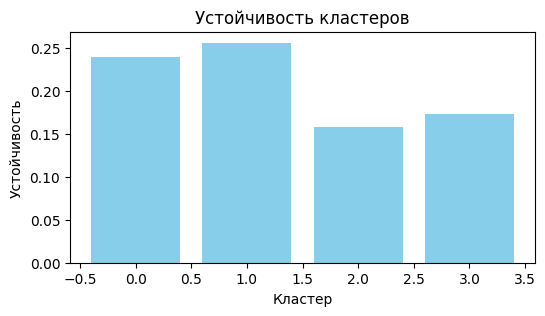

In [117]:
results = clstr_fncts.get_best_params_HDBSCAN(umap_std, min_sv)
best_params, labels_umap = results[0], results[2]

clstr_fncts.plot_best_params_HDBSCAN(umap_std, best_params)

In [125]:
np.unique(labels_umap, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([ 114, 2344, 1316, 2565,  627,  418]))

**Хммммм. Недурственно, недурственно. Итак, методом наглядного тыка необходимо выбирать либо tSNE, либо UMAP на HDBSCAN'e.**

#### **3.3.4. Ради прикола попробуем метод силуэта**

In [11]:
for i, name in enumerate(df_std.columns):
    X = df_std.iloc[:, [i, 7]].values
    EDAFunctions.get_best_k(X, name)

Best score for AT    : 0.46, k = 4
Best score for AP    : 0.42, k = 8
Best score for AH    : 0.41, k = 4
Best score for AFDP  : 0.6, k = 3
Best score for GTEP  : 0.61, k = 3
Best score for TIT   : 0.68, k = 3
Best score for TAT   : 0.63, k = 4
Best score for TEY   : 0.68, k = 3
Best score for CDP   : 0.68, k = 3
Best score for CO    : 0.57, k = 2
Best score for NOX   : 0.45, k = 5


# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных. 

In [118]:
df_umap_cl = df.copy()
df_umap_cl["cluster"] = labels_umap
df_g_umap = df_umap_cl.groupby('cluster').agg(['mean', 'std']).T
df_g_umap

cluster             -1            0            1            2            3  \
AT   mean    13.240312    20.660991    11.751648    14.682408    23.502598   
     std     12.858567     9.046273     5.633315     6.156063     3.616793   
AP   mean  1022.477193  1013.878643  1013.625623  1016.030296  1012.980383   
     std      9.817521     6.723709     6.726004     7.455453     3.214332   
AH   mean    69.930096    65.257940    67.051077    73.554202    68.556750   
     std     12.112304    14.255869    12.500812    11.795519    14.281122   
AFDP mean     3.787993     4.316573     3.254299     3.027132     3.831146   
     std      0.456802     0.209702     0.239502     0.329003     0.125140   
GTEP mean    27.188009    31.015299    26.484603    21.623991    24.778526   
     std      6.496265     1.924179     3.023001     2.164586     0.606608   
TIT  mean  1079.372807  1099.354650  1077.760334  1058.580078  1080.268421   
     std     19.327413     3.413895     7.816215    15.435475     2.981582   
TAT  mean   540.252456   541.295542   549.819658   548.898881   549.892217   
     std     13.261778     5.456405     0.823276     2.978154     0.620669   
TEY  mean   140.274649   151.989812   132.466938   117.984620   130.460590   
     std     26.139953     6.615718     4.994927    10.251862     1.795279   
CDP  mean    12.550728    13.427727    11.819550    10.978983    11.933611   
     std      1.711933     0.411245     0.374471     0.634949     0.146572   
CO   mean     2.647792     2.016415     3.250262     4.604395     2.046720   
     std      1.095571     1.906121     1.018710     2.541629     0.444591   
NOX  mean    51.973307    54.203358    68.758426    63.073011    53.291041   
     std      7.207233     5.442267     6.897653    14.214736     4.106825   

cluster              4  
AT   mean    22.466227  
     std      3.358048  
AP   mean  1011.611483  
     std      3.678841  
AH   mean    62.357431  
     std     12.226556  
AFDP mean     3.768150  
     std      0.137576  
GTEP mean    27.010313  
     std      0.814398  
TIT  mean  1091.613636  
     std      4.076243  
TAT  mean   549.645574  
     std      1.138337  
TEY  mean   139.703014  
     std      2.695287  
CDP  mean    12.490581  
     std      0.193330  
CO   mean     1.704725  
     std      0.396172  
NOX  mean    56.392469  
     std      2.966803

In [119]:
df_tsne_cl = df.copy()
df_tsne_cl["cluster"] = labels_tsne
df_g_tsne = df_tsne_cl.groupby('cluster').agg(['mean', 'std']).T
df_g_tsne

cluster             -1            0            1            2
AT   mean    24.262600    15.674003    25.587260     7.935374
     std      3.600000     6.921308     4.835221     5.230109
AP   mean  1014.100000  1014.754907  1010.895347  1021.788940
     std      3.271425     6.872849     4.124206     6.450219
AH   mean    70.187400    70.337228    63.149656    69.445853
     std      4.312187    12.964409    14.092484    12.922137
AFDP mean     4.131040     3.264815     4.351620     4.278067
     std      0.155987     0.413951     0.145534     0.245783
GTEP mean    27.975300    23.813866    30.295706    33.544081
     std      0.933866     3.229876     0.967960     1.580442
TIT  mean  1093.610000  1069.514680  1099.695650  1099.717819
     std      3.561663    16.813419     1.303360     1.645036
TAT  mean   547.794000   549.296200   543.904997   532.925115
     std      1.408862     2.349821     2.722168     4.223456
TEY  mean   141.655000   125.496602   148.972290   161.942627
     std      3.351249    11.368872     2.893571     5.177162
CDP  mean    12.722500    11.467786    13.264298    14.018515
     std      0.221833     0.736086     0.192043     0.308484
CO   mean     1.805825     3.699493     1.641906     2.499804
     std      0.617966     2.443038     0.637835     0.760063
NOX  mean    53.601500    62.613897    52.947881    56.435538
     std      2.260346    12.110240     3.909866     5.686103

Для сравнения кластеризации, выполненной после уменьшения размерности UMAP и t-SNE, важно оценить:

1. **Интерпретируемость кластеров**.
2. **Качество разбиения на кластеры**.
3. **Число кластеров и их характеристики**.
4. **Влияние шума (-1 кластер) и обоснованность его доли.**
5. **Сходства и различия между кластерами**.

---

### **1. Анализ кластеров UMAP**

**Общие наблюдения:**
- **6 кластеров, включая шум (-1)**. Включение шума может указывать на выделение объектов, которые сложно классифицировать.
- Кластеры различаются по энергоотдаче турбины (TEY), выбросам CO и NOX, температуре (AT), и некоторым другим характеристикам.

**Характеристики кластеров:**
- **Кластер 0**: Высокая энергоотдача (TEY), умеренная температура окружающей среды (AT) и выбросы CO/NOX. Стабильные значения большинства параметров.
- **Кластер 1**: Низкая энергоотдача (TEY) и относительно высокая температура окружающей среды (AT). Самые низкие выбросы CO.
- **Кластер 2**: Средняя энергоотдача (TEY), умеренная температура (AT) и выбросы. Промежуточное положение.
- **Кластер 3**: Очень высокая температура (AT) и низкие выбросы CO. Наиболее стабильные значения.
- **Кластер 4**: Средняя температура (AT), низкие выбросы CO, стабильные показатели энергоотдачи (TEY).
- **Шум (-1)**: Аномальные данные с высокой вариацией, возможно, экстренные случаи или некорректные измерения.

**Достоинства:**
- Детализация: наличие 5 чётко выделенных кластеров.
- Высокая интерпретируемость благодаря различиям по ключевым признакам (TEY, CO, NOX, AT).

---

### **2. Анализ кластеров t-SNE**

**Общие наблюдения:**
- **4 кластера, включая шум (-1)**. Меньшее число кластеров может свидетельствовать о слиянии групп с похожими характеристиками.
- Кластеры сильно различаются по энергоотдаче (TEY), выбросам и температуре (AT).

**Характеристики кластеров:**
- **Кластер 0**: Средние значения энергоотдачи (TEY), умеренная температура (AT), высокий уровень выбросов NOX.
- **Кластер 1**: Самая высокая энергоотдача (TEY), высокая температура (AT), самые низкие выбросы CO.
- **Кластер 2**: Низкая энергоотдача (TEY), умеренная температура (AT), высокие выбросы CO.
- **Шум (-1)**: Высокая температура, выбросы NOX. Возможно, аномалии.

**Достоинства:**
- Простота интерпретации: меньшее число кластеров.
- Хорошая сегментация по ключевым признакам (TEY, CO, NOX, AT).

---

### **3. Сравнительный анализ**

| Критерий                     | UMAP                        | t-SNE                       |
|------------------------------|-----------------------------|-----------------------------|
| **Число кластеров**          | 6 (вкл. шум)                | 4 (вкл. шум)                |
| **Доля шума**                | Высокая                     | Средняя                     |
| **Интерпретируемость**       | Выделены 5 уникальных групп | Группы более обобщённые     |
| **Вариативность признаков**  | Лучше учитывает дисперсию   | Упрощённые различия         |
| **Энергоотдача (TEY)**       | Высокая детализация         | Менее детализирована        |
| **Выбросы (CO, NOX)**        | Хорошо сегментированы       | Сходные результаты          |
| **Температура (AT)**         | Сложная сегментация         | Более грубое разделение     |
| **Скорость работы**          | Выше                        | Ниже                        |

---

### **4. Рекомендации**

- Если важна детализация и сегментация: **UMAP**.
- Если цель — обобщённые группы для упрощённого анализа: **t-SNE**.
- Учитывая, что кластеры UMAP разделены по ключевым признакам (TEY, выбросы), их можно использовать для глубокого анализа и разработки индивидуальных стратегий управления.

---

### **5. Визуализация кластеров**

#### **UMAP**

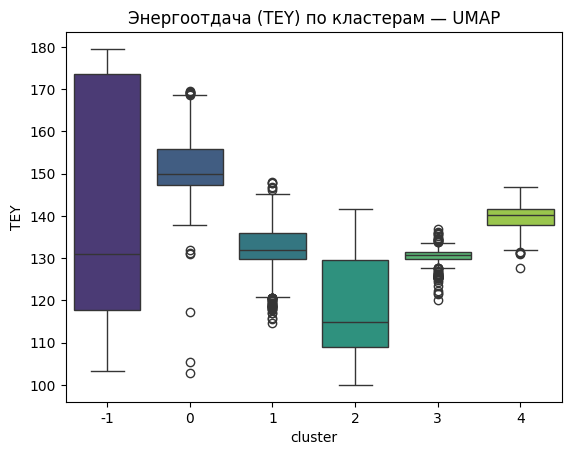

In [137]:
# data=df[feat], orient="h"
sns.boxplot(data=df_umap_cl, x="cluster", y="TEY", palette="viridis")
plt.title("Энергоотдача (TEY) по кластерам — UMAP")
plt.show()

#### **t-SNE**

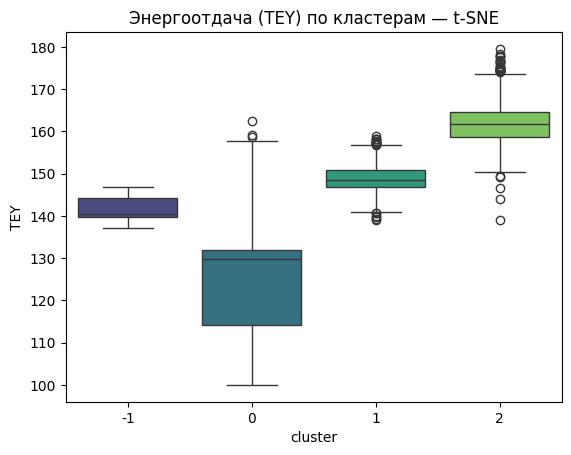

In [132]:
sns.boxplot(data=df_tsne_cl, x="cluster", y="TEY", palette="viridis")
plt.title("Энергоотдача (TEY) по кластерам — t-SNE")
plt.show()

#### **Шум**

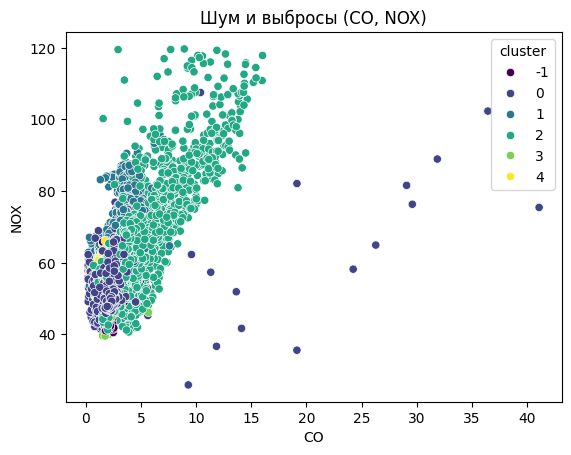

In [136]:
sns.scatterplot(x=df_umap_cl['CO'], y=df_umap_cl['NOX'], hue=df_umap_cl['cluster'], palette="viridis")
plt.title("Шум и выбросы (CO, NOX)")
plt.show()


### **Вывод**

Метод UMAP обеспечивает более точную и детализированную сегментацию данных, что важно для разработки управленческих решений. Однако t-SNE может быть удобнее, если цель анализа — быстрое обобщение данных. Выбор зависит от целей задачи: исследование деталей (UMAP) или общих трендов (t-SNE).